In [98]:
import numpy as np
from numpy.linalg import eig, inv, pinv, eigvals
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix, random as sparse_random, find, issparse
from scipy.sparse.linalg import svds
from scipy.linalg import eigh
from scipy.sparse.linalg import eigs

from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvnpdf
import cvxpy as cp
import time
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from numpy.matlib import repmat
import scipy.sparse as sp
import jax.numpy as jnp
from scipy.stats import boxcox



In [99]:


import numpy as np
from scipy.spatial.distance import squareform
from sklearn.metrics import precision_score, recall_score, f1_score, normalized_mutual_info_score

def graph_learning_perf_eval(L_0, L):
    """
    Evaluates the performance of a learned graph by comparing it with the ground truth Laplacian matrix.

    Parameters:
    -----------
    L_0 : np.ndarray
        Ground truth Laplacian matrix of shape (n, n).
    
    L : np.ndarray
        Learned Laplacian matrix of shape (n, n).

    Returns:
    --------
    precision : float
        Precision score of the learned graph.
    
    recall : float
        Recall score of the learned graph.
    
    f : float
        F1 score of the learned graph.
    
    NMI_score : float
        Normalized Mutual Information score of the learned graph.
    
    num_of_edges : int
        Number of edges in the learned graph.
    """
    # Edges in the ground truth graph
    L_0tmp = L_0 - np.diag(np.diag(L_0))
    L_0tmp = (L_0tmp + L_0tmp.T) / 2  
    edges_groundtruth = squareform(L_0tmp) != 0

    # Edges in the learned graph
    Ltmp = L - np.diag(np.diag(L))
    Ltmp = (Ltmp + Ltmp.T) / 2  
    edges_learned = squareform(Ltmp) != 0

    # Compute precision, recall, F1-score
    precision = precision_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)
    recall = recall_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)
    f = f1_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)

    # NMI
    NMI_score = normalized_mutual_info_score(edges_learned.astype(int), edges_groundtruth.astype(int))
    if np.isnan(NMI_score):
        NMI_score = 0

    # Number of edges in the learned graph
    num_of_edges = np.sum(edges_learned)

    return precision, recall, f, NMI_score, num_of_edges


import numpy as np

def identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k):
    """
    Identifies and compares clusters based on given Laplacian matrices and cluster assignments.

    Parameters:
    -----------
    Ls : np.ndarray
        Estimated Laplacian matrices of shape (n, n, k).
    
    Lap : np.ndarray
        Ground truth Laplacian matrices of shape (n, n, k).
    
    gamma_hats : np.ndarray
        Estimated cluster assignments of shape (m, k).
    
    gamma_cut : np.ndarray
        Ground truth cluster assignments of shape (m, k).
    
    k : int
        Number of clusters.

    Returns:
    --------
    identify : np.ndarray
        Indices of the identified clusters of shape (k,).
    
    precision : np.ndarray
        Precision scores for each cluster of shape (k,).
    
    recall : np.ndarray
        Recall scores for each cluster of shape (k,).
    
    f : np.ndarray
        F1 scores for each cluster of shape (k,).
    
    cl_errors : np.ndarray
        Clustering errors for each cluster of shape (k,).
    
    NMI_score : np.ndarray
        Normalized Mutual Information scores for each cluster of shape (k,).
    
    num_of_edges : np.ndarray
        Number of edges for each cluster of shape (k,).
    """
    identify = np.zeros(k, dtype=int)
    cl_err = np.inf * np.ones(k)
    precision = np.zeros(k)
    recall = np.zeros(k)
    f = np.zeros(k)
    NMI_score = np.zeros(k)
    num_of_edges = np.zeros(k)

    for i in range(k):
        W = np.diag(np.diag(Ls[:, :, i])) - Ls[:, :, i]
        W[W < 0.001] = 0
        Ls[:, :, i] = np.diag(np.sum(W, axis=1)) - W
        for j in range(k):
            er = np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, j])
            if cl_err[i] > er:
                cl_err[i] = er
                identify[i] = j

    for i in range(k):
        idx = identify[i]
        precision[i], recall[i], f[i], NMI_score[i], num_of_edges[i] = graph_learning_perf_eval(Lap[:, :, idx], Ls[:, :, i])

    # Compute clustering errors
    cl_errors = np.array([np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, identify[i]]) for i in range(k)])

    return identify, precision, recall, f, cl_errors, NMI_score, num_of_edges



def generate_connected_graph(n, p, zero_thresh):
    """
    Generates a connected Erdos-Renyi graph and returns its Laplacian matrix.

    Parameters:
    -----------
    n : int
        Number of nodes in the graph.
    
    p : float
        Probability for edge creation in the Erdos-Renyi graph.
    
    zero_thresh : float
        Threshold for the second smallest eigenvalue of the Laplacian matrix
        to ensure graph connectivity.

    Returns:
    --------
    np.ndarray
        Laplacian matrix of the generated connected graph.
    """
    while True:
        g = nx.erdos_renyi_graph(n, p)
        L = nx.laplacian_matrix(g).toarray()
        eigs = np.sort(eigvals(L))
        if eigs[1] > zero_thresh:
            return L

In [100]:
def squareform_sp(w):
    """
    Sparse counterpart of numpy's squareform
    
    Parameters:
    w : sparse vector with n(n-1)/2 elements OR matrix with size [n, n] and zero diagonal
    
    Returns:
    W : matrix form of input vector w OR vector form of input matrix W
    """
    # If input is not sparse, check density
    if not sp.issparse(w):
        density = np.count_nonzero(w) / w.size
        if density > 1/10:
            # Use standard squareform for non-sparse data
            return squareform(w)
        else:
            # Proceed with the function using NumPy arrays
            pass
    
    if w.ndim == 1 or w.shape[0] == 1 or w.shape[1] == 1:  # It's a vector
        # VECTOR -> MATRIX
        l = w.size
        n = int(round((1 + np.sqrt(1 + 8*l)) / 2))
        
        # Check input
        if l != n*(n-1)//2:
            raise ValueError("Bad vector size!")
        
        ind_vec = w.nonzero()[0]
        s = w[ind_vec]
        num_nz = len(ind_vec)
        
        ind_i = np.zeros(num_nz, dtype=int)
        ind_j = np.zeros(num_nz, dtype=int)
        
        curr_row = 0
        offset = 0
        len_row = n - 1
        for idx in range(num_nz):
            ind_vec_i = ind_vec[idx]
            while ind_vec_i >= (len_row + offset):
                offset += len_row
                len_row -= 1
                curr_row += 1
            ind_i[idx] = curr_row
            ind_j[idx] = ind_vec_i - offset + curr_row + 1
        
        # For the lower triangular part just add the transposed matrix
        data = np.concatenate([s, s])
        row_indices = np.concatenate([ind_i, ind_j])
        col_indices = np.concatenate([ind_j, ind_i])
        W = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n, n))
        return W

    else:
        # MATRIX -> VECTOR
        m, n = w.shape
        if m != n or not np.all(np.diagonal(w) == 0):
            raise ValueError("Matrix has to be square with zero diagonal!")
        
        ind_i, ind_j = w.nonzero()
        s = w[ind_i, ind_j]
        
        # Keep only upper triangular part
        ind_upper = ind_i < ind_j
        ind_i = ind_i[ind_upper]
        ind_j = ind_j[ind_upper]
        s = s[ind_upper]
        
        # Compute new (vector) index from (i,j) (matrix) indices
        new_ind = n * ind_i - ind_i * (ind_i + 1) // 2 + ind_j - ind_i - 1
        l = n * (n - 1) // 2
        w_vec = sp.csr_matrix((s, (new_ind, np.zeros_like(new_ind))), shape=(l, 1))
        return w_vec


# def sum_squareform(n, mask=None):
#     """
#     Computes the sum and transpose sum matrices in a squareform format.

#     Parameters:
#     -----------
#     n : int
#         The size of the squareform matrix.
    
#     mask : array-like, optional
#         A mask to filter the indices. The length of the mask must be n(n-1)/2.
#         If provided, only the elements corresponding to the non-zero values in
#         the mask are considered.

#     Returns:
#     --------
#     S : csr_matrix
#         A sparse matrix of shape (n, n) representing the sum matrix.
    
#     St : csr_matrix
#         A sparse matrix of shape (n, n) representing the transpose sum matrix.

#     Raises:
#     -------
#     ValueError
#         If the length of the mask is not equal to n(n-1)/2.
#     """
#     if mask is not None:
#         mask = np.asarray(mask).flatten()
#         if len(mask) != n * (n - 1) // 2:
#             raise ValueError('Mask size has to be n(n-1)/2')

#         ind_vec = np.flatnonzero(mask)
#         ncols = len(ind_vec)

#         I = np.zeros(ncols, dtype=int)
#         J = np.zeros(ncols, dtype=int)

#         curr_row = 0
#         offset = 0
#         len_row = n - 1
#         for ii in range(ncols):
#             ind_vec_i = ind_vec[ii]
#             while ind_vec_i >= (len_row + offset):
#                 offset += len_row
#                 len_row -= 1
#                 curr_row += 1
#             I[ii] = curr_row
#             J[ii] = ind_vec_i - offset + curr_row + 1

#     else:
#         ncols = (n * (n - 1)) // 2
#         I = np.zeros(ncols, dtype=int)
#         J = np.zeros(ncols, dtype=int)

#         k = 0
#         for i in range(n):
#             for j in range(i + 1, n):
#                 I[k] = i
#                 J[k] = j
#                 k += 1

#     St = csr_matrix((np.ones(ncols), (np.arange(ncols), I)), shape=(ncols, n))
#     S = csr_matrix((np.ones(ncols), (np.arange(ncols), J)), shape=(ncols, n)).T + St.T

#     return S, St

def sum_squareform(n, mask=None):
    """
    Computes the sum and transpose sum matrices in a squareform format.

    Parameters:
    -----------
    n : int
        The size of the squareform matrix.
    
    mask : array-like, optional
        A mask to filter the indices. The length of the mask must be n(n-1)/2.
        If provided, only the elements corresponding to the non-zero values in
        the mask are considered.

    Returns:
    --------
    S : csr_matrix
        A sparse matrix so that S * w = sum(W), where w = squareform(W)
    
    St : csr_matrix
        The adjoint of S.

    Raises:
    -------
    ValueError
        If the length of the mask is not equal to n(n-1)/2.
    """
    if mask is not None:
        mask = np.asarray(mask).flatten()
        if len(mask) != n * (n - 1) // 2:
            raise ValueError('Mask size has to be n(n-1)/2')

        ind_vec = np.flatnonzero(mask)
        ncols = len(ind_vec)

        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        curr_row = 0
        offset = 0
        len_row = n - 1
        for ii in range(ncols):
            ind_vec_i = ind_vec[ii]
            while ind_vec_i > (len_row + offset - 1):
                offset += len_row
                len_row -= 1
                curr_row += 1
            I[ii] = curr_row
            J[ii] = ind_vec_i - offset + curr_row + 1
    else:
        ncols = n * (n - 1) // 2
        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        k = 0
        for i in range(n - 1):
            for j in range(i + 1, n):
                I[k] = i
                J[k] = j
                k += 1

    # Construct St
    row_indices = np.concatenate([np.arange(ncols), np.arange(ncols)])
    col_indices = np.concatenate([I, J])
    data = np.ones(2 * ncols)

    St = csr_matrix((data, (row_indices, col_indices)), shape=(ncols, n))
    S = St.transpose()

    return S, St


def normest(S):
    """
    Estimate the 2-norm (largest singular value) of a sparse matrix S.
    """
    u, s, vt = svds(S, k=1)
    return s[0]


# def prox_sum_log(x, gamma, param=None):
#     """
#     Proximal operator of log-barrier - sum(log(x))
    
#     Parameters:
#     x : Input signal (vector or matrix)
#     gamma : Regularization parameter
#     param : Dictionary of optional parameters
    
#     Returns:
#     sol : Solution
#     info : Dictionary summarizing information at convergence
#     """
#     if param is None:
#         param = {}
    
#     verbose = param.get('verbose', 1)
    
#     if gamma < 0:
#         raise ValueError('Gamma cannot be negative')
#     elif gamma == 0:
#         stop_error = True
#     else:
#         stop_error = False
    
#     t1 = time.time()
    
#     if stop_error:
#         sol = x
#         info = {
#             'algo': 'prox_sum_log',
#             'iter': 0,
#             'final_eval': 0,
#             'crit': '--',
#             'time': time.time() - t1
#         }
#         return sol, info
    
#     sol = (x + np.sqrt(x**2 + 4*gamma)) / 2
#     final_eval = -gamma * np.sum(np.log(x[x > 0]))  # Ignore non-positive elements for log
    
#     info = {
#         'algo': 'prox_sum_log',
#         'iter': 0,
#         'final_eval': final_eval,
#         'crit': '--',
#         'time': time.time() - t1
#     }
    
#     if verbose >= 1:
#         print(f'  prox_sum_log: - sum(log(x)) = {info["final_eval"] / gamma:.6e}')
#         if verbose > 1:
#             n_neg = np.sum(x <= 0)
#             if n_neg > 0:
#                 print(f' ({n_neg} negative elements, log not defined, check stability)')
#         print()
    
#     return sol, info

def prox_sum_log(x, gamma, param=None):
    """
    Proximal operator of log-barrier - sum(log(x))
    
    Solves:
        sol = argmin_{z} 0.5*||x - z||_2^2 - gamma * sum(log(z))
    
    Parameters:
    ----------
    x : array-like
        Input signal (vector or matrix).
    gamma : float
        Regularization parameter.
    param : dict, optional
        Dictionary of optional parameters:
        - 'verbose': int, verbosity level (default: 1).
    
    Returns:
    -------
    sol : numpy.ndarray
        Solution to the optimization problem.
    info : dict
        Dictionary summarizing information at convergence.
    """
    if param is None:
        param = {}
    
    verbose = param.get('verbose', 1)
    
    if gamma < 0:
        raise ValueError('Gamma cannot be negative')
    elif gamma == 0:
        stop_error = True
    else:
        stop_error = False
    
    t1 = time.time()
    
    if stop_error:
        sol = x
        info = {
            'algo': 'prox_sum_log',
            'iter': 0,
            'final_eval': 0,
            'crit': '--',
            'time': time.time() - t1
        }
        return sol, info
    
    # Compute the solution
    sol = (x + np.sqrt(x**2 + 4*gamma)) / 2
    
    # Compute the final evaluation of the function
    final_eval = -gamma * np.sum(np.log(x.flatten()))
    
    info = {
        'algo': 'prox_sum_log',
        'iter': 0,
        'final_eval': final_eval,
        'crit': '--',
        'time': time.time() - t1
    }
    
    # Verbose output
    if verbose >= 1:
        print(f'  prox_sum_log: - sum(log(x)) = {info["final_eval"] / gamma:.6e}')
        if verbose > 1:
            n_neg = np.sum(x.flatten() <= 0)
            if n_neg > 0:
                print(f' ({n_neg} negative elements, log not defined, check stability)')
        print()
    
    return sol, info




def lin_map(X, lims_out, lims_in=None):
    """
    Map linearly from a given range to another.

    Parameters:
    X : array-like
        Input array.
    lims_out : list or tuple
        Output limits [c, d].
    lims_in : list or tuple, optional
        Input limits [a, b]. If not specified, the minimum and maximum values of X are used.

    Returns:
    Y : array-like
        Linearly mapped output array.
    """
    X = np.asarray(X)
    
    if lims_in is None:
        lims_in = [np.min(X), np.max(X)]
    
    a, b = lims_in
    c, d = lims_out
    
    Y = (X - a) * ((d - c) / (b - a)) + c
    return Y



def gsp_distanz(X, Y=None, P=None):
    """
    Calculates the distances between all vectors in X and Y using a provided matrix P for scaling (weighted distances).
    
    Parameters:
        X (numpy.ndarray): Matrix with column vectors of shape (n_features, n_samples_X).
        Y (numpy.ndarray, optional): Matrix with column vectors of shape (n_features, n_samples_Y). Defaults to X.
        P (numpy.ndarray, optional): Weight matrix of shape (n_features, n_features). Defaults to the identity matrix.

    Returns:
        numpy.ndarray: Distance matrix of shape (n_samples_X, n_samples_Y), not squared.
        
    Raises:
        ValueError: If the dimensions of X and Y do not match.
        ValueError: If the dimensions of P do not match the number of features in X.

    Usage:
        D = gsp_distanz(X, Y, P)
        
    Notes:
        This function computes the following:
        
            D = sqrt((X - Y)^T P (X - Y))
        
        for all vectors in X and Y. If P is not provided, it defaults to the identity matrix, reducing the calculation to the Euclidean distance.
        The function is optimized for speed using vectorized operations, avoiding explicit loops.
    """
    
    if Y is None:
        Y = X
    
    if X.shape[0] != Y.shape[0]:
        raise ValueError("The sizes of X and Y do not match!")

    n_features, n_samples_X = X.shape
    _, n_samples_Y = Y.shape
    
    if P is None:
        xx = np.sum(X**2, axis=0)  # ||x||^2
        yy = np.sum(Y**2, axis=0)  # ||y||^2
        xy = X.T @ Y  # <y,x>
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    else:
        rp, rp2 = P.shape
        if n_features != rp or rp != rp2:
            raise ValueError("P must be square and match the dimension of X!")

        xx = np.sum(X * (P @ X), axis=0)  # x^T P x
        yy = np.sum(Y * (P @ Y), axis=0)  # y^T P y
        xy = X.T @ (P @ Y)  # x^T P y
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    
    if np.any(D < 0):
        print('Warning: P is not semipositive or x is not real!')

    D = np.sqrt(D)
    
    if Y is X:
        np.fill_diagonal(D, 0)

    return D

# Example usage
def generate_example_data(n=256):
    G_coords = np.random.rand(n, 2)
    f1 = lambda x, y: np.sin((2 - x - y) ** 2)
    f2 = lambda x, y: np.cos((x + y) ** 2)
    f3 = lambda x, y: (x - 0.5) ** 2 + (y - 0.5) ** 3 + x - y
    f4 = lambda x, y: np.sin(3 * ((x - 0.5) ** 2 + (y - 0.5) ** 2))
    X = np.vstack([f1(G_coords[:, 0], G_coords[:, 1]),
                   f2(G_coords[:, 0], G_coords[:, 1]),
                   f3(G_coords[:, 0], G_coords[:, 1]),
                   f4(G_coords[:, 0], G_coords[:, 1])]).T
    return G_coords, X


def visualize_glmm(Ls, gamma_hats):
    k = gamma_hats.shape[1]
    n = Ls.shape[0]
    
    G = nx.Graph()
    
    for i in range(n):
        G.add_node(i)
    
    for l in range(k):
        L = Ls[:, :, l]
        for i in range(n):
            for j in range(i+1, n):
                if L[i, j] != 0:
                    G.add_edge(i, j, weight=L[i, j])
    
    colors = []
    for i in range(n):
        cluster = np.argmax(gamma_hats[i])
        colors.append(cluster)
    
    pos = nx.spring_layout(G)  
    
    nx.draw_networkx_nodes(G, pos, node_size=700, cmap=plt.cm.RdYlBu, node_color=colors)
    
    edges = G.edges(data=True)
    weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
    
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    
    plt.title('Graph Laplacian Mixture Model (GLMM) Visualization')
    plt.show()
    
    
    
def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    """
    Learns a graph structure by optimizing a log-degrees model.

    Parameters:
    -----------
    Z : array-like
        Input data matrix or condensed distance matrix.

    a : float
        Coefficient for the logarithmic penalty term.

    b : float
        Regularization coefficient.

    params : dict, optional
        A dictionary of optional parameters:
        - 'W_init': Initial weight matrix (default: zeros)
        - 'verbosity': int, level of verbosity (default: 1)
        - 'maxit': int, maximum number of iterations (default: 1000)
        - 'tol': float, tolerance for convergence (default: 1e-5)
        - 'step_size': float, step size for the gradient descent (default: 0.5)
        - 'max_w': float, maximum allowable weight (default: np.inf)
        - 'w_0': array-like or int, initial weight matrix or value (default: 0)
        - 'c': float, regularization coefficient for initial weight matrix
        - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
        - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

    Returns:
    --------
    W : array-like
        The learned weight matrix.

    stat : dict
        Optional output statistics.

    Raises:
    -------
    ValueError
        If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
    """
    # Default parameters
    if params is None:
        params = {}

    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)
    w_0 = params.get('w_0', 0)

    # Initialize z
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        z = Z.copy()
    else:
        z = squareform_sp(Z)

    z = z.flatten()
    l = len(z)
    n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

    # Handle w_0
    if not np.isscalar(w_0) or w_0 != 0:
        if 'c' not in params:
            raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
        else:
            c = params['c']
        if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
            w_0 = w_0.copy()
        else:
            w_0 = squareform_sp(w_0)
        w_0 = w_0.flatten()
    else:
        w_0 = 0

    # Handle fix_zeros
    if fix_zeros:
        if 'edge_mask' not in params:
            raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
        edge_mask = params['edge_mask']
        if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
            edge_mask = squareform_sp(edge_mask)
        ind = np.nonzero(edge_mask.flatten())[0]
        z = z[ind]
        if not np.isscalar(w_0):
            w_0 = w_0[ind]
    else:
        edge_mask = None

    # Initialize w
    w = np.zeros_like(z)

    # Needed operators
    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)

    K_op = lambda w: S @ w
    Kt_op = lambda z: St @ z

    if fix_zeros:
        norm_K = normest(S)
    else:
        norm_K = np.sqrt(2 * (n - 1))

    # Define functions f, g, h
    f_eval = lambda w: 2 * np.dot(w, z)
    f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

    param_prox_log = {'verbose': verbosity - 3}
    g_eval = lambda s: -a * np.sum(np.log(s))
    g_prox = lambda s, c: prox_sum_log(s, c * a, param_prox_log)[0]
    g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]

    if np.all(w_0 == 0):
        h_eval = lambda w: b * np.linalg.norm(w) ** 2
        h_grad = lambda w: 2 * b * w
        h_beta = 2 * b
    else:
        h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0) ** 2
        h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
        h_beta = 2 * (b + c)

    # Parameters for convergence
    mu = h_beta + norm_K
    epsilon = 1e-6  # A small positive value
    gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

    # Initialize variables
    v_n = K_op(w)

    stat = {}
    if verbosity > 1:
        stat['f_eval'] = []
        stat['g_eval'] = []
        stat['h_eval'] = []
        stat['fgh_eval'] = []
        stat['pos_violation'] = []

    start_time = time.time()

    # Iterative optimization
    for i in range(maxit):
        # Primal and dual updates
        Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn * K_op(w)
        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn * K_op(P_n)

        # Compute relative norms
        rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
        rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

        if verbosity > 1:
            # Record statistics
            stat['f_eval'].append(f_eval(w))
            stat['g_eval'].append(g_eval(K_op(w)))
            stat['h_eval'].append(h_eval(w))
            stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
            stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
            print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

        # Update variables
        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        # Check convergence
        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    total_time = time.time() - start_time
    if verbosity > 0:
        print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {f_eval(w) + g_eval(K_op(w)) + h_eval(w):6.3e}')
        print(f'Time needed is {total_time} seconds')

    # Reconstruct full weight vector if fix_zeros was used
    if fix_zeros:
        w_full = np.zeros(l)
        w_full[ind] = w
        w = w_full

    # Convert vectorized weights back to matrix form
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        W = w
    else:
        W = squareform_sp(w)

    stat['time'] = total_time

    return W, stat


# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.

#     Parameters:
#     -----------
#     Z : array-like
#         Input data matrix or condensed distance matrix.
    
#     a : float
#         Coefficient for the logarithmic penalty term.
    
#     b : float
#         Regularization coefficient.
    
#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'verbosity': int, level of verbosity (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size for the gradient descent (default: 0.5)
#         - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight matrix or value (default: 0)
#         - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)
#         - 'c': float, regularization coefficient for initial weight matrix

#     Returns:
#     --------
#     W : array-like
#         The learned weight matrix.

#     Raises:
#     -------
#     ValueError
#         If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
#     """
#     if params is None:
#         params = {}

#     # Default parameters
#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)
#     w_0 = params.get('w_0', 0)

#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z
#     else:
#         z = squareform(Z)

#     z = z.flatten().astype(np.float64) 
#     l = len(z)
#     n = round((1 + np.sqrt(1 + 8 * l)) / 2)  # number of nodes

#     if w_0 != 0:
#         if 'c' not in params:
#             raise ValueError('When params.w_0 is specified, params.c should also be specified')
#         else:
#             c = params['c']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0
#         else:
#             w_0 = squareform(w_0)
#         w_0 = w_0.flatten().astype(np.float64) 
#     else:
#         w_0 = 0

#     if fix_zeros:
#         if isinstance(params['edge_mask'], np.ndarray) and params['edge_mask'].ndim == 1:
#             edge_mask = params['edge_mask']
#         else:
#             edge_mask = squareform(params['edge_mask'])
#         ind = np.where(edge_mask.flatten() > 0)[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None

#     z=np.asarray(z)
#     w_0 = np.asarray(w_0)
#     w = np.zeros_like(z)

#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask)
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     if fix_zeros:
#         norm_K = normest(S)
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     f_eval = lambda w: 2 * np.dot(w.T, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     g_eval = lambda z: -a * np.sum(np.log(np.clip(z, 1e-10, None))) # Avoid log(0)
#     g_prox = lambda z, c: prox_sum_log(np.clip(z, 1e-10, None), c * a, param_prox_log)[0]  # Avoid log(0) in prox
#     g_star_prox = lambda z, c: z - c * a * g_prox(z / (c * a), 1 / (c * a))

#     if np.all(w_0 == 0):
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2
#         h_grad = lambda w: 2 * b * w
#         h_beta = 2 * b
#     else:
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0,'fro') ** 2
#         h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
#         h_beta = 2 * (b + c)

#     mu = h_beta + norm_K
#     epsilon = lin_map(0.0, [0, 1 / (1 + mu)], [0, 1])
#     gn = lin_map(step_size, [epsilon, (1 - epsilon) / mu], [0, 1])

#     v_n = K_op(w)
#     stat = {
#         'f_eval': np.full(maxit, np.nan),
#         'g_eval': np.full(maxit, np.nan),
#         'h_eval': np.full(maxit, np.nan),
#         'fgh_eval': np.full(maxit, np.nan),
#         'pos_violation': np.full(maxit, np.nan),
#         'time': 0
#     }

#     start_time = time.time()

#     for i in range(maxit):
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         stat['f_eval'][i] = f_eval(w)
#         stat['g_eval'][i] = g_eval(K_op(w))
#         stat['h_eval'][i] = h_eval(w)
#         stat['fgh_eval'][i] = stat['f_eval'][i] + stat['g_eval'][i] + stat['h_eval'][i]
#         stat['pos_violation'][i] = -np.sum(np.minimum(0, w))

#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)  # Avoid divide by zero
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)  # Avoid divide by zero

#         if verbosity > 1:
#             print(f'iter {i:4d}: {rel_norm_primal:6.4e} {rel_norm_dual:6.4e}')

#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     stat['time'] = time.time() - start_time

#     if verbosity > 0:
#         print(f'# iters: {i:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e} OBJ {f_eval(w) + g_eval(K_op(w)) + h_eval(w):6.3e}')
#         print(f'Time needed is {stat["time"]} seconds')

#     if fix_zeros:
#         w = np.array([w[ind]])

#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform(w)

#     return W




# def graph_learning_perf_eval(L_0, L):
#     """
#     Evaluates the performance of a learned graph by comparing it with the ground truth Laplacian matrix.

#     Parameters:
#     -----------
#     L_0 : np.ndarray
#         Ground truth Laplacian matrix of shape (n, n).
    
#     L : np.ndarray
#         Learned Laplacian matrix of shape (n, n).

#     Returns:
#     --------
#     precision : float
#         Precision score of the learned graph.
    
#     recall : float
#         Recall score of the learned graph.
    
#     f : float
#         F1 score of the learned graph.
    
#     NMI_score : float
#         Normalized Mutual Information score of the learned graph.
    
#     num_of_edges : int
#         Number of edges in the learned graph.
#     """
#     # Edges in the ground truth graph
#     L_0tmp = L_0 - np.diag(np.diag(L_0))
#     L_0tmp = (L_0tmp + L_0tmp.T) / 2  
#     edges_groundtruth = squareform(L_0tmp) != 0

#     # Edges in the learned graph
#     Ltmp = L - np.diag(np.diag(L))
#     Ltmp = (Ltmp + Ltmp.T) / 2  
#     edges_learned = squareform(Ltmp) != 0

#     # Recall & precision
#     precision, recall, _ = precision_recall_curve(edges_groundtruth.astype(int), edges_learned.astype(int))
#     precision = precision[1] if len(precision) > 1 else 0
#     recall = recall[1] if len(recall) > 1 else 0

#     # F-measure
#     if precision + recall == 0:
#         f = 0
#     else:
#         f = 2 * precision * recall / (precision + recall)

#     # NMI
#     NMI_score = nmi(edges_learned.astype(int), edges_groundtruth.astype(int))
#     if np.isnan(NMI_score):
#         NMI_score = 0

#     # Number of edges in the learned graph
#     num_of_edges = np.sum(edges_learned)

#     return precision, recall, f, NMI_score, num_of_edges



# def identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k):
#     """
#     Identifies and compares clusters based on given Laplacian matrices and cluster assignments.

#     Parameters:
#     -----------
#     Ls : np.ndarray
#         Estimated Laplacian matrices of shape (n, n, k).
    
#     Lap : np.ndarray
#         Ground truth Laplacian matrices of shape (n, n, k).
    
#     gamma_hats : np.ndarray
#         Estimated cluster assignments of shape (m, k).
    
#     gamma_cut : np.ndarray
#         Ground truth cluster assignments of shape (m, k).
    
#     k : int
#         Number of clusters.

#     Returns:
#     --------
#     identify : np.ndarray
#         Indices of the identified clusters of shape (k,).
    
#     precision : np.ndarray
#         Precision scores for each cluster of shape (k,).
    
#     recall : np.ndarray
#         Recall scores for each cluster of shape (k,).
    
#     f : np.ndarray
#         F1 scores for each cluster of shape (k,).
    
#     cl_errors : np.ndarray
#         Clustering errors for each cluster of shape (k,).
    
#     NMI_score : np.ndarray
#         Normalized Mutual Information scores for each cluster of shape (k,).
    
#     num_of_edges : np.ndarray
#         Number of edges for each cluster of shape (k,).
#     """
#     identify = np.zeros(k, dtype=int)
#     cl_err = np.inf * np.ones(k)
#     precision = np.zeros(k)
#     recall = np.zeros(k)
#     f = np.zeros(k)
#     NMI_score = np.zeros(k)
#     num_of_edges = np.zeros(k)

#     for i in range(k):
#         W = np.diag(np.diag(Ls[:, :, i])) - Ls[:, :, i]
#         W[W < 0.001] = 0
#         Ls[:, :, i] = np.diag(np.sum(W, axis=1)) - W
#         for j in range(k):
#             er = np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, j])
#             if cl_err[i] > er:
#                 cl_err[i] = er
#                 identify[i] = j

#     for i in range(k):
#         precision[i], recall[i], f[i], NMI_score[i], num_of_edges[i] = graph_learning_perf_eval(Lap[:, :, identify[i]], Ls[:, :, i])

#     cl_errors = np.diag((gamma_hats - gamma_cut[:, identify]).T @ (gamma_hats - gamma_cut[:, identify]))

#     return identify, precision, recall, f, cl_errors, NMI_score, num_of_edges


# def generate_connected_graph(n, p, zero_thresh):
#     """
#     Generates a connected Erdos-Renyi graph and returns its Laplacian matrix.

#     Parameters:
#     -----------
#     n : int
#         Number of nodes in the graph.
    
#     p : float
#         Probability for edge creation in the Erdos-Renyi graph.
    
#     zero_thresh : float
#         Threshold for the second smallest eigenvalue of the Laplacian matrix
#         to ensure graph connectivity.

#     Returns:
#     --------
#     np.ndarray
#         Laplacian matrix of the generated connected graph.
#     """
#     while True:
#         g = nx.erdos_renyi_graph(n, p)
#         L = nx.laplacian_matrix(g).toarray()
#         eigs = np.sort(eigvals(L))
#         if eigs[1] > zero_thresh:
#             return L

In [101]:
def adaptive_transfer_function(eigenvalues, t):
    """
    Applies the Adaptive Transfer Function to a set of eigenvalues derived from the normalized Laplacian
    of a graph. This function is tailored for use in spectral graph wavelet analysis.

    Parameters:
    ----------
    eigenvalues : array-like
        A 1D array of positive eigenvalues from the normalized Laplacian matrix of a graph.
    t : float
        The scaling parameter for the adaptive transfer function, controlling the diffusion scale.

    Returns:
    -------
    transformed_eigenvalues : numpy.ndarray
        The Box-Cox transformed eigenvalues.
    g_t : numpy.ndarray
        The adaptive transfer function values corresponding to each transformed eigenvalue.
    kappa : float
        The optimal Box-Cox transformation parameter.

    Raises:
    ------
    ValueError
        If any eigenvalue is non-positive, since Box-Cox requires positive data.
    """
    # Convert input to a NumPy array for efficient computations
    eigenvalues = np.asarray(eigenvalues)

    # Ensure all eigenvalues are positive
    if np.any(eigenvalues <= 0):
        raise ValueError("All eigenvalues must be positive for Box-Cox transformation.")

    # Apply Box-Cox transformation
    transformed_eigenvalues, kappa = boxcox(eigenvalues)

    # Compute sample mean and standard deviation of transformed eigenvalues
    mu = np.mean(transformed_eigenvalues)
    sigma = np.std(transformed_eigenvalues, ddof=1)  # Sample standard deviation

    # Compute the sum of transformed eigenvalues
    c = np.sum(transformed_eigenvalues)

    # Initialize g_t array with the same shape as transformed_eigenvalues
    g_t = np.empty_like(transformed_eigenvalues)

    # Define conditions based on the value of transformed eigenvalues
    cond1 = transformed_eigenvalues < mu
    cond2 = (transformed_eigenvalues >= mu) & (transformed_eigenvalues < mu + sigma)
    cond3 = (transformed_eigenvalues >= mu + sigma) & (transformed_eigenvalues < mu + 2 * sigma)
    cond4 = transformed_eigenvalues >= mu + 2 * sigma

    # Apply the adaptive transfer function based on the defined conditions
    g_t[cond1] = np.exp(-transformed_eigenvalues[cond1] * (1 + 2 * t / c))
    g_t[cond2] = np.exp(-transformed_eigenvalues[cond2] * (1 + 3 * t / c + sigma))
    g_t[cond3] = np.exp(-transformed_eigenvalues[cond3] * (1 + 4 * t / c + sigma))
    g_t[cond4] = np.exp(-transformed_eigenvalues[cond4] * (1 + 5 * t / c + sigma))

    return transformed_eigenvalues, g_t, kappa


def plot_transfer_function(eigenvalues, g_t, title="Adaptive Transfer Function"):
    """
    Plots the adaptive transfer function values against the original eigenvalues.

    Parameters:
    ----------
    eigenvalues : array-like
        Original eigenvalues from the normalized Laplacian.
    g_t : array-like
        Adaptive transfer function values.
    title : str
        Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues, g_t, 'bo-', markersize=5)
    plt.xlabel('Eigenvalues (λ)')
    plt.ylabel('Adaptive Transfer Function g_t(λ)')
    plt.title(title)
    plt.grid(True)
    plt.show()
    

In [102]:


def awglmm(y, iterations, classes,t = 0.5, spread=0.1, regul=0.15, norm_par=1.5):
    """
    Implements a Graph Laplacian Mixture Model (GLMM) 

    Parameters:
    -----------
    y : np.ndarray
        The input data matrix of shape (m, n) where m is the number of signals
        and n is the number of features.
    
    iterations : int
        The number of iterations for the algorithm.
    
    classes : int
        The number of clusters (classes).
    
    spread : float, optional
        Spread parameter for initializing the Laplacian matrices (default: 0.1).
    
    regul : float, optional
        Regularization parameter for the covariance matrices (default: 0.15).
    
    norm_par : float, optional
        Normalization parameter for the distance computation (default: 1.5).

    Returns:
    --------
    L : np.ndarray
        The learned Laplacian matrices of shape (n, n, classes).
    
    gamma_hat : np.ndarray
        The cluster probabilities of shape (m, classes).
    
    mu : np.ndarray
        The cluster means of shape (n, classes).
    
    log_likelihood : np.ndarray
        The log-likelihood values over the iterations.

    Raises:
    -------
    ValueError
        If the dimensions of the input data are not correct.
    """
    
    delta = 2
    n = y.shape[1]
    m = y.shape[0]

    # Initialize variables
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n-1, n-1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n-1, classes))
    log_likelihood = np.zeros(iterations)

    for cls in range(classes):
        L[:, :, cls] = spread * np.eye(n) - spread / n * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu[:, cls] = mu_curr - np.mean(mu_curr)
        p[cls] = 1 / classes

    # Start the algorithm
    for it in range(iterations):
        # Expectation step
        pall = 0
        for cls in range(classes):
            # vecl[:, :, cls], vall[:, :, cls] = eig(L[:, :, cls])
            eig_vals, eig_vecs = np.linalg.eig(L[:, :, cls])
            eig_vecs = np.real(eig_vecs)
            eig_vals = np.real(eig_vals)
            eig_vals[eig_vals < 0] = 1e-5
            vecl[:, :, cls] = eig_vecs
            
            eigenvalues_to_filter = eig_vals[1:]
            transformed_eigenvalues, g_t, kappa = adaptive_transfer_function(eigenvalues_to_filter, t)

            # Construct filtered eigenvalues including the first eigenvalue
            filtered_eigenvalues = np.concatenate(([eig_vals[0]], g_t))
            vall[:, :, cls] = np.diag(filtered_eigenvalues)
            
            sigma[:, :, cls] = inv(vall[1:n, 1:n, cls] + regul * np.eye(n-1))  
            sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2
            yl[:, :, cls] = (y - mu[:, cls].T) @ vecl[:, 1:n, cls]
            pall += p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])

        # Compute cluster probabilities gamma_hat  
        pall[pall == 0] = 0.1
        for cls in range(classes):
            gamma_hat[:, cls] = (p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])) / pall

        log_likelihood[it] = np.sum(np.log(pall))

        # Maximization step: update mu, W, and p
        for cls in range(classes):
            mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])
            yc = repmat(np.sqrt(gamma_hat[:, cls])[:, np.newaxis], 1, n) * (y - mu[:, cls])
            Z = gsp_distanz(yc) ** 2
            theta = np.mean(Z) / norm_par
            W_curr = delta * (gsp_learn_graph_log_degrees(Z / theta, 1, 1))[0]
            W[:, :, cls] = W_curr
            p[cls] = np.sum(gamma_hat[:, cls]) / m
            # Compute Ls
            L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]
            W_curr[W_curr < 1e-3] = 0
            W[:, :, cls] = W_curr

    return L, gamma_hat, mu, log_likelihood



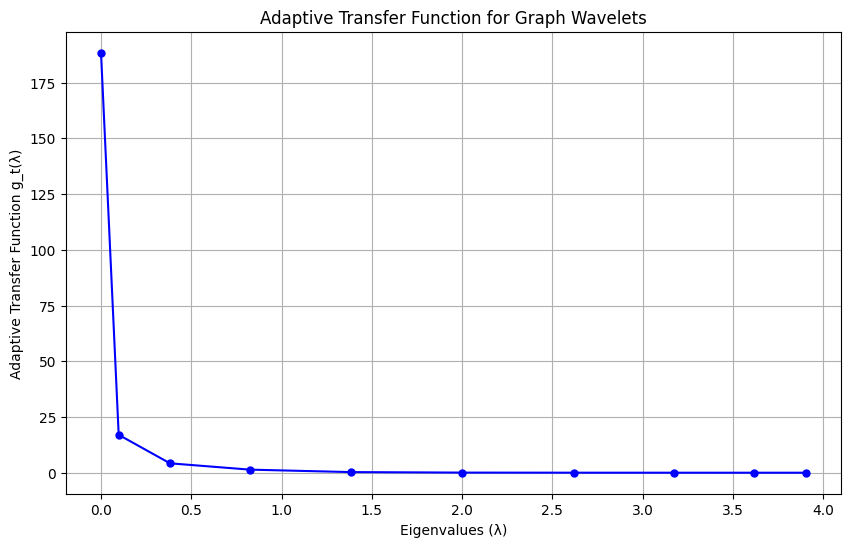

In [103]:

    
G = nx.path_graph(10)
L = nx.laplacian_matrix(G).toarray()

    # Compute normalized Laplacian eigenvalues
eigenvalues , _= np.linalg.eigh(L)
epsilon = 1e-6
eigenvalues_shifted = eigenvalues + epsilon

t = 0.5

transformed, g_t, kappa = adaptive_transfer_function(eigenvalues_shifted, t)
plot_transfer_function(eigenvalues_shifted, g_t, title="Adaptive Transfer Function for Graph Wavelets")


/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: divide by zero encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: invalid value encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))


# iters:   47. Rel primal: 9.6539e-06 Rel dual: 2.7927e-06  OBJ 1.204e+01
Time needed is 0.008983135223388672 seconds
# iters:   47. Rel primal: 9.0250e-06 Rel dual: 2.1160e-06  OBJ 1.194e+01
Time needed is 0.0022521018981933594 seconds
# iters:   47. Rel primal: 9.2008e-06 Rel dual: 3.3830e-06  OBJ 1.213e+01
Time needed is 0.002161264419555664 seconds
# iters:   62. Rel primal: 8.8026e-06 Rel dual: 2.3814e-06  OBJ 1.721e+01
Time needed is 0.003213167190551758 seconds
# iters:   47. Rel primal: 9.4336e-06 Rel dual: 3.4063e-06  OBJ 1.214e+01
Time needed is 0.002858877182006836 seconds
# iters:   73. Rel primal: 7.8177e-06 Rel dual: 8.0387e-07  OBJ 2.042e+01
Time needed is 0.003256082534790039 seconds
# iters:   47. Rel primal: 9.8607e-06 Rel dual: 3.3737e-06  OBJ 1.214e+01
Time needed is 0.0022211074829101562 seconds
# iters:   59. Rel primal: 9.8409e-06 Rel dual: 1.6845e-06  OBJ 1.745e+01
Time needed is 0.0027892589569091797 seconds
# iters:   47. Rel primal: 9.1421e-06 Rel dual: 2.788

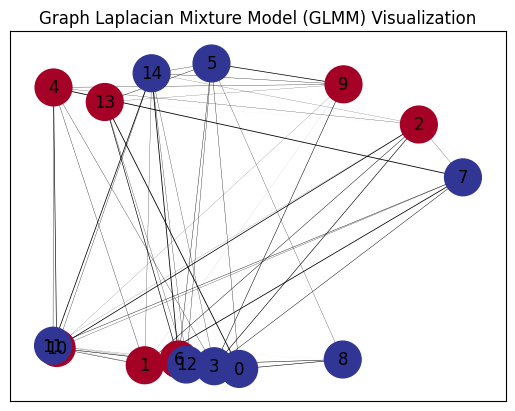

In [104]:

n = 15  
m = 150  
k = 2
zero_thresh = 10e-4

g = [generate_connected_graph(n, 0.7, zero_thresh) for _ in range(k)]

gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
dist = 0.5
p = np.linspace(0, 1, k + 1)
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))
center = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(g[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = g[i]
    center[:, i] = dist * np.random.randn(n)
    center[:, i] = center[:, i] - np.mean(center[:, i])
    gamma_cut[(p[i] < gamma[:, 0]) & (gamma[:, 0] <= p[i + 1]), i] = 1
    true_y[:, :, i] = gamma_cut[:, i][:, np.newaxis] * np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
    y += true_y[:, :, i]

iterations = 200
Ls, gamma_hats, mus, log_likelihood = awglmm(y, iterations, k)
print('Training done')

print(np.sum(gamma_hats, axis=0))

identify, precision, recall, f, cl_errors ,NMI_score , num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

print("Identify:", identify)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f)
print("Cluster Errors:", cl_errors)
print('Normalized mutual information', NMI_score)
print("Number of estimated edges", num_of_edges)
summed_gamma_hats = np.sum(gamma_hats, axis=1)
summed_gamma_hats_column = summed_gamma_hats[:, np.newaxis]
are_all_elements_one = np.allclose(summed_gamma_hats_column, 1, atol=1e-8)
print("\nAre all elements in the colum wise summed gamma_hat equal to 1:", are_all_elements_one)
visualize_glmm(Ls, gamma_hats)

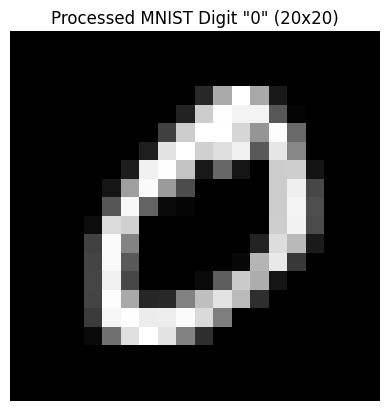

Flattened image shape: (400,)


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from skimage.transform import resize

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Convert the data and target to NumPy arrays
X = mnist.data.to_numpy().astype(np.float64)
y = mnist.target.astype(int)

# Get indices of digit 0 images
digit_0_indices = np.where(y == 0)[0]

# Extract the first digit 0 image (28x28 pixels)
first_digit_0 = X[digit_0_indices[0]].reshape(28, 28)

# Resize the image to 20x20 pixels
first_digit_0_resized = resize(first_digit_0, (20, 20), anti_aliasing=True)

# Flatten the resized image to match the desired dimension (400)
first_digit_0_flat = first_digit_0_resized.flatten()

# Visualize the processed 20x20 digit 0 image
plt.imshow(first_digit_0_resized, cmap='gray')
plt.title('Processed MNIST Digit "0" (20x20)')
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Print the shape of the flattened image to confirm it's 400-dimensional
print("Flattened image shape:", first_digit_0_flat.shape)


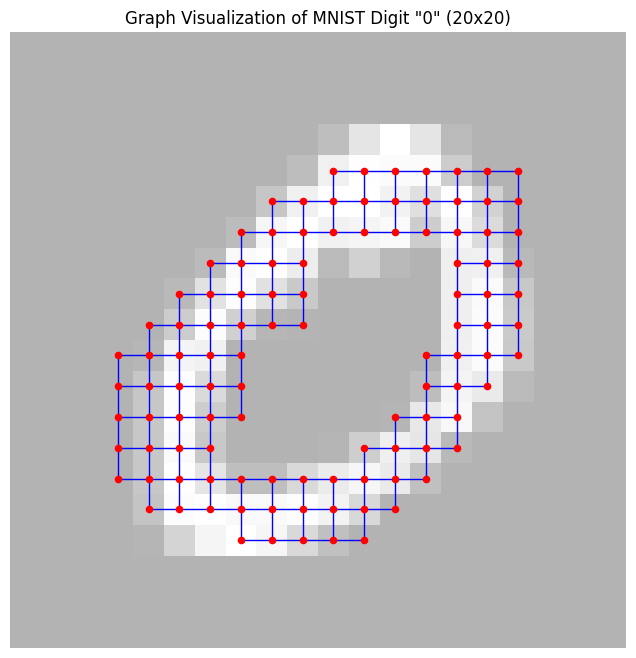

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import fetch_openml
from skimage.transform import resize

# Fetch MNIST data
mnist = fetch_openml('mnist_784', version=1)

# Convert data and target to NumPy arrays
X = mnist.data.to_numpy().astype(np.float64)
y = mnist.target.astype(int)

# Get indices of digit 0 images
digit_0_indices = np.where(y == 0)[0]

# Extract the first digit 0 image (28x28 pixels)
first_digit_0 = X[digit_0_indices[0]].reshape(28, 28)

# Resize the image to 20x20 pixels
first_digit_0_resized = resize(first_digit_0, (20, 20), anti_aliasing=True)

# Function to construct a graph based on pixel adjacency and threshold
def create_pixel_graph(image, threshold=0.5):
    """
    Create a graph based on pixel adjacency for the given image.
    Nodes represent pixels, and edges connect neighboring pixels with significant values.
    :param image: 2D array of pixel intensities
    :param threshold: Threshold for considering a pixel as significant
    :return: A networkx graph
    """
    G = nx.Graph()
    rows, cols = image.shape

    # Add nodes (each node is a pixel)
    for i in range(rows):
        for j in range(cols):
            if image[i, j] > threshold:
                G.add_node((i, j), intensity=image[i, j])

    # Add edges between neighboring significant pixels
    for i in range(rows):
        for j in range(cols):
            if image[i, j] > threshold:
                # Check right neighbor
                if j + 1 < cols and image[i, j + 1] > threshold:
                    G.add_edge((i, j), (i, j + 1))
                # Check bottom neighbor
                if i + 1 < rows and image[i + 1, j] > threshold:
                    G.add_edge((i, j), (i + 1, j))

    return G

# Create a graph from the resized image
pixel_graph = create_pixel_graph(first_digit_0_resized, threshold=0.5)

# Visualize the graph
def visualize_pixel_graph(G, image):
    """
    Visualize the graph of significant pixel connections.
    :param G: NetworkX graph
    :param image: Original 2D image for context
    """
    plt.figure(figsize=(8, 8))
    
    # Plot the original image in the background
    plt.imshow(image, cmap='gray', alpha=0.3)
    
    # Extract node positions (pixel coordinates)
    positions = {node: node for node in G.nodes()}
    
    # Draw the graph on top of the image
    nx.draw(G, pos=positions, node_size=20, node_color='red', edge_color='blue', with_labels=False)
    
    plt.title('Graph Visualization of MNIST Digit "0" (20x20)')
    plt.axis('off')
    plt.show()

# Visualize the graph
visualize_pixel_graph(pixel_graph, first_digit_0_resized)


/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: divide by zero encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: invalid value encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))


# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.291140079498291 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.27524781227111816 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.28660106658935547 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.2985210418701172 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.28492093086242676 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.30210208892822266 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.262833833694458 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  OBJ -7.756e+02
Time needed is 0.28612399101257324 seconds
# iters:  134. Rel primal: 3.4361e-06 Rel dual: 9.2265e-06  O

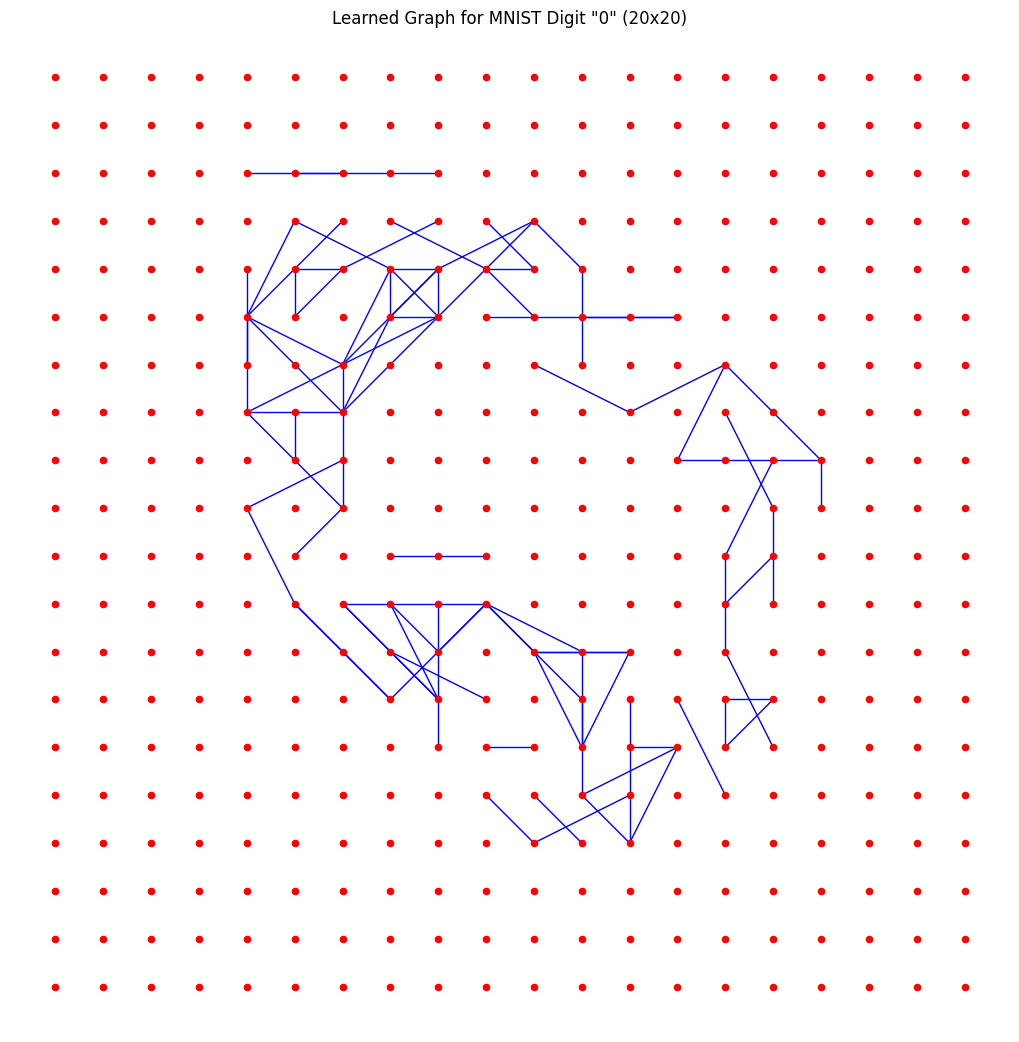

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import fetch_openml
from skimage.transform import resize

# Assuming you have the GLMM function 'awglmm' defined elsewhere
# from your_glmm_module import awglmm

# Fetch MNIST data
mnist = fetch_openml('mnist_784', version=1)

# Convert the data and target to NumPy arrays
X = mnist.data.to_numpy().astype(np.float64)
y = mnist.target.astype(int)

# Get indices of digit 0 images
digit_0_indices = np.where(y == 0)[0]

# Extract the first digit 0 image (28x28 pixels)
first_digit_0 = X[digit_0_indices[0]].reshape(28, 28)

# Resize the image to 20x20 pixels
first_digit_0_resized = resize(first_digit_0, (20, 20), anti_aliasing=True).flatten()

# Stack the resized image to create a dataset for the GLMM algorithm
X_digit_0_resized = np.tile(first_digit_0_resized, (500, 1))  # Simulate 500 samples for training

# Apply the GLMM algorithm
iterations = 100
classes = 6
L, gamma_hat, mu, log_likelihood = awglmm(X_digit_0_resized, iterations, classes)

print('Training done')
print('Sum of gamma_hat:', np.sum(gamma_hat, axis=0))

# Visualize the learned graph
def visualize_learned_graph(L, significant_pixels=None):
    """
    Visualize the learned graph from the Laplacian matrix.
    Only edges between 2-hop neighboring pixels are allowed.
    :param L: The Laplacian matrix learned from GLMM (n x n x classes).
    :param significant_pixels: Optionally pass significant pixel coordinates.
    """
    # L is the Laplacian matrix
    # Compute the adjacency matrix W
    W = np.diag(np.diag(L)) - L

    # Threshold the weights for visualization
    threshold = np.percentile(W, 99)
    W_thresholded = np.copy(W)
    W_thresholded[W_thresholded < threshold] = 0

    # Filter edges to allow only 2-hop neighboring pixels
    filtered_W = np.zeros_like(W_thresholded)
    for i in range(20 * 20):
        # Get the row and column coordinates in the 20x20 grid
        row, col = divmod(i, 20)
        # Define the neighbors within 2 hops
        for dr in range(-2, 3):
            for dc in range(-2, 3):
                if 0 <= row + dr < 20 and 0 <= col + dc < 20:
                    j = (row + dr) * 20 + (col + dc)
                    filtered_W[i, j] = W_thresholded[i, j]
    
    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(filtered_W)

    # Define positions for the nodes (20x20 grid layout)
    positions = {i: (i % 20, i // 20) for i in range(20 * 20)}

    # Visualize the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos=positions, node_size=20, node_color='red', edge_color='blue', with_labels=False)
    plt.title('Learned Graph for MNIST Digit "0" (20x20)')
    plt.axis('off')
    plt.show()

# Visualize the learned graph for the first class
visualize_learned_graph(L[:, :, 0])


In [67]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler


# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)

# Convert data and target to NumPy arrays
X = mnist.data.to_numpy().astype(np.float64)
y = mnist.target.astype(int).to_numpy()

# Get indices of digit 0 images
digit_0_indices = np.where(y == 0)[0]

# Extract digit 0 images
X_digit_0 = X[digit_0_indices]

# Limit the number of samples for computational efficiency
num_samples = 500  # Use fewer samples
X_digit_0 = X_digit_0[:num_samples]


# Apply the GLMM algorithm
iterations = 100
classes = 6
L, gamma_hat, mu, log_likelihood = awglmm(X_digit_0, iterations, classes)

print('Training done')
print('Sum of gamma_hat:', np.sum(gamma_hat, axis=0))

# Visualize the learned graph
def visualize_learned_graph(L, significant_pixels=None):
    # L is the Laplacian matrix
    # Compute the adjacency matrix W
    W = np.diag(np.diag(L)) - L

    # Threshold the weights for visualization
    threshold = np.percentile(W, 99)
    W_thresholded = np.copy(W)
    W_thresholded[W_thresholded < threshold] = 0

    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(W_thresholded)

    # Define positions for the nodes (since we reduced dimensions, positions are arbitrary)
    positions = nx.spring_layout(G)

    # Visualize the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos=positions, node_size=50)
    plt.title('Learned Graph for MNIST Digit "0"')
    plt.show()

# Visualize the graph
visualize_learned_graph(L[:, :, 0])

/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/2545599681.py:101: RuntimeWarning: invalid value encountered in divide
  mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])


ValueError: Distance matrix 'X' must be symmetric.

/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: divide by zero encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: invalid value encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))


# iters:   63. Rel primal: 9.6104e-06 Rel dual: 3.7393e-07  OBJ 3.947e+01
Time needed is 0.006232261657714844 seconds
# iters:   71. Rel primal: 8.4631e-06 Rel dual: 8.3309e-07  OBJ 3.726e+01
Time needed is 0.007804155349731445 seconds
# iters:   63. Rel primal: 9.1638e-06 Rel dual: 5.3108e-07  OBJ 3.950e+01
Time needed is 0.0027570724487304688 seconds
# iters:   70. Rel primal: 9.5941e-06 Rel dual: 1.4388e-06  OBJ 3.723e+01
Time needed is 0.002882242202758789 seconds
# iters:   64. Rel primal: 9.5986e-06 Rel dual: 8.2240e-07  OBJ 3.934e+01
Time needed is 0.005409955978393555 seconds
# iters:   74. Rel primal: 9.2011e-06 Rel dual: 1.3369e-06  OBJ 3.674e+01
Time needed is 0.003072977066040039 seconds
# iters:   65. Rel primal: 9.4736e-06 Rel dual: 6.2307e-07  OBJ 3.911e+01
Time needed is 0.002790212631225586 seconds
# iters:   76. Rel primal: 9.0842e-06 Rel dual: 1.3884e-06  OBJ 3.677e+01
Time needed is 0.003113985061645508 seconds
# iters:   71. Rel primal: 8.7071e-06 Rel dual: 4.7298e

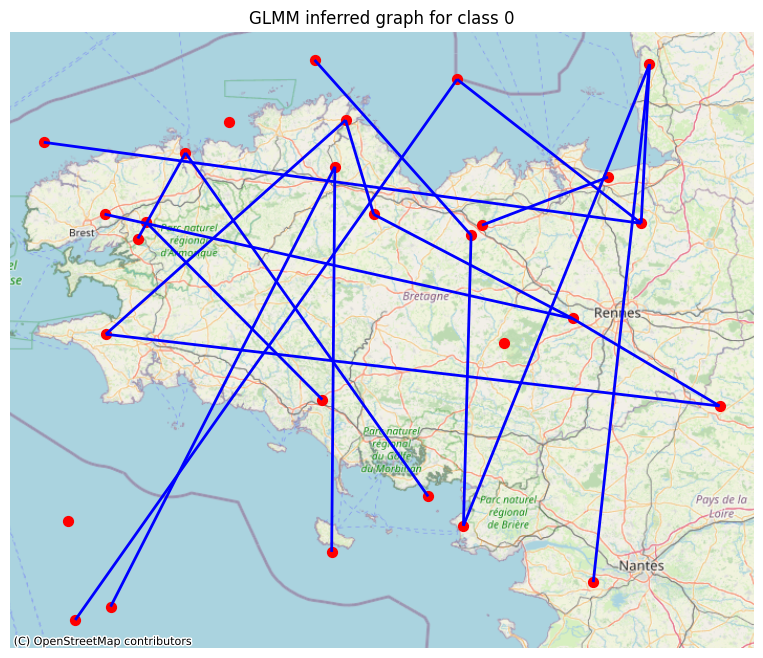

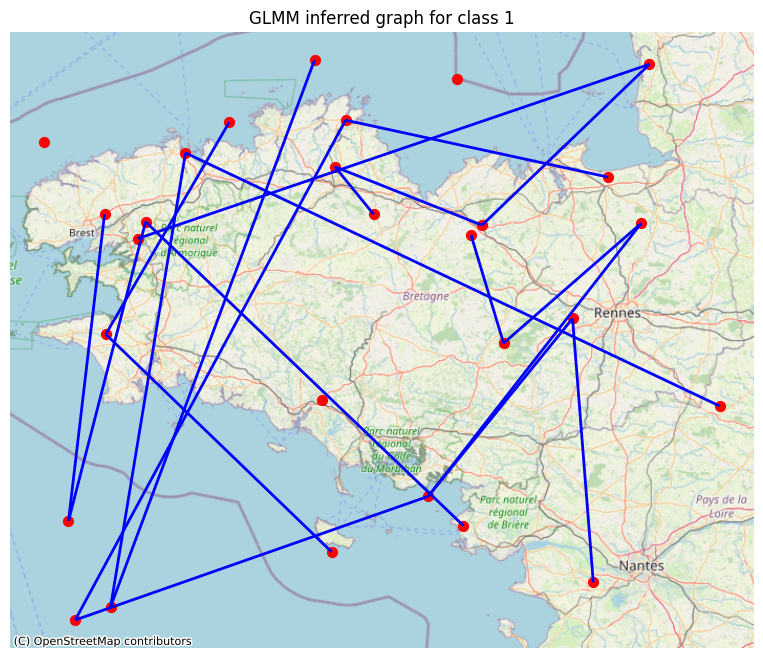

In [72]:
# Preprocessing function
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv
from scipy.stats import multivariate_normal
import contextily as ctx
from shapely.geometry import LineString, Point
def preprocess_data(temp_data, wind_data):
    # Subtract the mean of each signal (each sample)
    temp_data_centered = temp_data - np.mean(temp_data, axis=1, keepdims=True)
    wind_data_centered = wind_data - np.mean(wind_data, axis=1, keepdims=True)

    # Normalize both measures to ensure data is in the same range
    scaler_temp = StandardScaler()
    temp_data_scaled = scaler_temp.fit_transform(temp_data_centered)
    scaler_wind = StandardScaler()
    wind_data_scaled = scaler_wind.fit_transform(wind_data_centered)

    return temp_data_scaled, wind_data_scaled

# Function to create the dataset
def create_dataset(temp_data, wind_data, n_samples=300):
    # Randomly select n_samples from each measure
    n_total_samples_temp = temp_data.shape[0]
    n_total_samples_wind = wind_data.shape[0]

    indices_temp = np.random.choice(n_total_samples_temp, n_samples, replace=False)
    indices_wind = np.random.choice(n_total_samples_wind, n_samples, replace=False)

    temp_samples = temp_data[indices_temp, :]
    wind_samples = wind_data[indices_wind, :]

    # Create labels: 0 for temp, 1 for wind
    labels_temp = np.zeros(n_samples, dtype=int)
    labels_wind = np.ones(n_samples, dtype=int)

    # Combine the data
    data = np.vstack((temp_samples, wind_samples))
    labels = np.concatenate((labels_temp, labels_wind))

    return data, labels

# Visualization function with map background
def visualize_graphs_with_map(Ls, coordinates, method_name='GLMM'):
    classes = Ls.shape[2]
    for cls in range(classes):
        L = Ls[:, :, cls]
        # Compute the adjacency matrix W
        W = np.diag(np.diag(L)) - L
        # Threshold the weights for visualization
        threshold = np.percentile(W, 95)  # Adjust the percentile as needed
        W_thresholded = np.copy(W)
        W_thresholded[W_thresholded < threshold] = 0

        # Create the graph from the adjacency matrix
        G = nx.from_numpy_array(W_thresholded)

        # Set positions based on coordinates
        pos = {i: (coordinates[i, 0], coordinates[i, 1]) for i in range(coordinates.shape[0])}

        # Create GeoDataFrames for nodes and edges
        nodes_gdf = gpd.GeoDataFrame({
            'id': list(pos.keys()),
            'geometry': [Point(pos[i]) for i in pos]
        })

        edges = []
        for u, v in G.edges():
            line = LineString([pos[u], pos[v]])
            edges.append({'geometry': line, 'u': u, 'v': v})
        edges_gdf = gpd.GeoDataFrame(edges)

        # Set CRS (Coordinate Reference System) to WGS84 (EPSG:4326)
        nodes_gdf.set_crs(epsg=4326, inplace=True)
        edges_gdf.set_crs(epsg=4326, inplace=True)

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 8))

        # Add a basemap (OpenStreetMap)
        # Using contextily to add the map tiles
        nodes_gdf.to_crs(epsg=3857, inplace=True)
        edges_gdf.to_crs(epsg=3857, inplace=True)

        edges_gdf.plot(ax=ax, linewidth=2, edgecolor='blue')
        nodes_gdf.plot(ax=ax, markersize=50, color='red')

        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        # Set plot title and axis off
        plt.title(f'{method_name} inferred graph for class {cls}')
        plt.axis('off')
        plt.show()

# Main function
def main():
    # Load your data into temp_data, wind_data, and coordinates
    # Replace the following simulated data with your actual data
    n_stations = 28
    n_samples_temp = 744  # Total number of temperature measurements
    n_samples_wind = 744  # Total number of wind measurements

    # Load actual data
    # For example, if your data is in CSV files:
    # temp_data = np.loadtxt('temp_data.csv', delimiter=',')
    # wind_data = np.loadtxt('wind_data.csv', delimiter=',')
    # coordinates = np.loadtxt('coordinates.csv', delimiter=',')

    # Simulate some data (replace with actual data)
    temp_data = np.random.randn(n_samples_temp, n_stations)
    wind_data = np.random.randn(n_samples_wind, n_stations)

    # Simulate coordinates (replace with actual coordinates)
    # Coordinates should be in the format: [longitude, latitude]
    # Use actual longitude and latitude values of the stations
    # For demonstration, we generate random coordinates within the bounding box of Bretagne, France
    min_lon, max_lon = -5.5, -1.0
    min_lat, max_lat = 47.0, 49.0
    coordinates = np.column_stack((
        np.random.uniform(min_lon, max_lon, n_stations),
        np.random.uniform(min_lat, max_lat, n_stations)
    ))

    # Preprocess the data
    temp_data_scaled, wind_data_scaled = preprocess_data(temp_data, wind_data)

    # Create the dataset
    data, labels = create_dataset(temp_data_scaled, wind_data_scaled, n_samples=300)

    # Apply the GLMM algorithm
    iterations = 10
    classes = 2
    Ls, gamma_hat, mu, log_likelihood = awglmm(data, iterations, classes)

    print('Training done')
    print('Sum of gamma_hat:', np.sum(gamma_hat, axis=0))

    # Visualize the inferred graphs with map background
    visualize_graphs_with_map(Ls, coordinates, method_name='GLMM')

if __name__ == '__main__':
    main()

In [76]:
# Function to load and preprocess the data

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv
from scipy.stats import multivariate_normal
import contextily as ctx
from shapely.geometry import Point, LineString
import datetime



def load_and_preprocess_data():
    # Load Uber pickups data
    uber_data = pd.read_csv('/Users/paul_reitz/Downloads/uber-raw-data-sep14.csv')

    # Convert Date/Time to datetime object
    uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format='%m/%d/%Y %H:%M:%S')

    # Filter to working days (Monday to Friday)
    uber_data = uber_data[uber_data['Date/Time'].dt.weekday < 5]

    # Load NYC Taxi Zones shapefile
    taxi_zones = gpd.read_file('/Users/paul_reitz/Downloads/NYC Taxi Zones/geo_export_53f45597-1083-40ea-9e12-4891f9a4f723.shp')

    # For simplicity, we can reduce the number of zones to 29 by grouping smaller zones
    # Alternatively, select 29 significant zones
    # Here, we will select the top 29 zones by frequency in the data

    # Create a GeoDataFrame from Uber data
    geometry = [Point(xy) for xy in zip(uber_data['Lon'], uber_data['Lat'])]
    uber_geo = gpd.GeoDataFrame(uber_data, crs='EPSG:4326', geometry=geometry)

    # Spatial join to assign each pickup to a taxi zone
    uber_geo = uber_geo.sjoin(taxi_zones, how='inner', op='within')

    # Count pickups per zone
    zone_counts = uber_geo['LocationID'].value_counts()

    # Select top 29 zones
    top_zones = zone_counts.nlargest(29).index.tolist()

    # Filter data to include only pickups in top 29 zones
    uber_geo = uber_geo[uber_geo['LocationID'].isin(top_zones)]

    # Reindex zones from 0 to 28
    zone_mapping = {zone_id: idx for idx, zone_id in enumerate(top_zones)}
    uber_geo['ZoneID'] = uber_geo['LocationID'].map(zone_mapping)

    # Aggregate pickups per hour per zone
    uber_geo['Hour'] = uber_geo['Date/Time'].dt.hour
    uber_geo['Date'] = uber_geo['Date/Time'].dt.date

    # Create a pivot table: rows are hours, columns are zones
    hourly_pickups = uber_geo.pivot_table(index=['Date', 'Hour'], columns='ZoneID', values='Base', aggfunc='count', fill_value=0)

    # Flatten MultiIndex
    hourly_pickups.reset_index(inplace=True)

    # Create a datetime index
    hourly_pickups['DateTime'] = pd.to_datetime(hourly_pickups['Date'].astype(str) + ' ' + hourly_pickups['Hour'].astype(str), format='%Y-%m-%d %H')

    # Sort by datetime
    hourly_pickups.sort_values('DateTime', inplace=True)

    # Drop unnecessary columns
    hourly_pickups.drop(columns=['Date', 'Hour', 'DateTime'], inplace=True)

    # Replace NaNs with zeros (in case some zones have no pickups in certain hours)
    hourly_pickups.fillna(0, inplace=True)

    # Convert to NumPy array
    data = hourly_pickups.values

    # Normalize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    return data_scaled, zone_mapping, taxi_zones

# Visualization function
def visualize_graphs(Ls, zone_mapping, taxi_zones, method_name='GLMM'):
    classes = Ls.shape[2]
    n_zones = len(zone_mapping)
    # Reverse the zone_mapping to get LocationID for each ZoneID
    reverse_zone_mapping = {v: k for k, v in zone_mapping.items()}

    # Get centroids of zones
    zone_centroids = taxi_zones.set_index('LocationID').loc[reverse_zone_mapping.values()].centroid
    zone_centroids = zone_centroids.to_crs(epsg=3857)  # Convert to Web Mercator for plotting with contextily

    pos = {idx: (zone_centroids.loc[reverse_zone_mapping[idx]].x, zone_centroids.loc[reverse_zone_mapping[idx]].y) for idx in range(n_zones)}

    for cls in range(classes):
        L = Ls[:, :, cls]
        # Compute the adjacency matrix W
        W = np.diag(np.diag(L)) - L
        # Threshold the weights for visualization
        threshold = np.percentile(W, 95)  # Adjust the percentile as needed
        W_thresholded = np.copy(W)
        W_thresholded[W_thresholded < threshold] = 0

        # Create the graph from the adjacency matrix
        G = nx.from_numpy_array(W_thresholded)

        # Create GeoDataFrames for nodes and edges
        nodes_gdf = gpd.GeoDataFrame({
            'id': list(pos.keys()),
            'geometry': [Point(pos[i]) for i in pos]
        })

        edges = []
        for u, v in G.edges():
            line = LineString([pos[u], pos[v]])
            edges.append({'geometry': line, 'u': u, 'v': v})
        edges_gdf = gpd.GeoDataFrame(edges)

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot base map
        nodes_gdf.plot(ax=ax, markersize=50, color='red')
        edges_gdf.plot(ax=ax, linewidth=2, edgecolor='blue')

        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        # Set plot title and axis off
        plt.title(f'{method_name} inferred graph for class {cls}')
        plt.axis('off')
        plt.show()

# Main function
def main():
    # Load and preprocess data
    data_scaled, zone_mapping, taxi_zones = load_and_preprocess_data()

    # Apply the GLMM algorithm
    iterations = 10
    classes = 5
    Ls, gamma_hat, mu, log_likelihood = awglmm(data_scaled, iterations, classes)

    print('Training done')
    print('Sum of gamma_hat:', np.sum(gamma_hat, axis=0))

    # Visualize the inferred graphs
    visualize_graphs(Ls, zone_mapping, taxi_zones, method_name='GLMM')

if __name__ == '__main__':
    main()

/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/409408875.py:141: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  data_scaled, zone_mapping, taxi_zones = load_and_preprocess_data()
/Users/paul_reitz/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2177: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


KeyError: 'LocationID'

/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: divide by zero encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_41863/720349036.py:337: RuntimeWarning: invalid value encountered in log
  final_eval = -gamma * np.sum(np.log(x.flatten()))


# iters:  172. Rel primal: 9.2929e-06 Rel dual: 1.2710e-06  OBJ 7.117e+01
Time needed is 0.030910968780517578 seconds
# iters:  143. Rel primal: 9.5159e-06 Rel dual: 1.2774e-06  OBJ 1.026e+02
Time needed is 0.016705989837646484 seconds
# iters:  145. Rel primal: 9.8919e-06 Rel dual: 2.0454e-06  OBJ 1.050e+02
Time needed is 0.015767812728881836 seconds
# iters:  258. Rel primal: 9.9401e-06 Rel dual: 4.3362e-06  OBJ 9.973e+01
Time needed is 0.02916717529296875 seconds
# iters:  420. Rel primal: 8.5563e-06 Rel dual: 8.0832e-06  OBJ 9.436e+01
Time needed is 0.04631805419921875 seconds
# iters:  207. Rel primal: 9.9094e-06 Rel dual: 3.2173e-06  OBJ 6.294e+01
Time needed is 0.03108525276184082 seconds
# iters:  158. Rel primal: 9.9954e-06 Rel dual: 1.7050e-06  OBJ 9.529e+01
Time needed is 0.017323017120361328 seconds
# iters:  268. Rel primal: 9.7647e-06 Rel dual: 4.6341e-06  OBJ 9.092e+01
Time needed is 0.03952217102050781 seconds
# iters:  205. Rel primal: 9.8943e-06 Rel dual: 4.5496e-06  

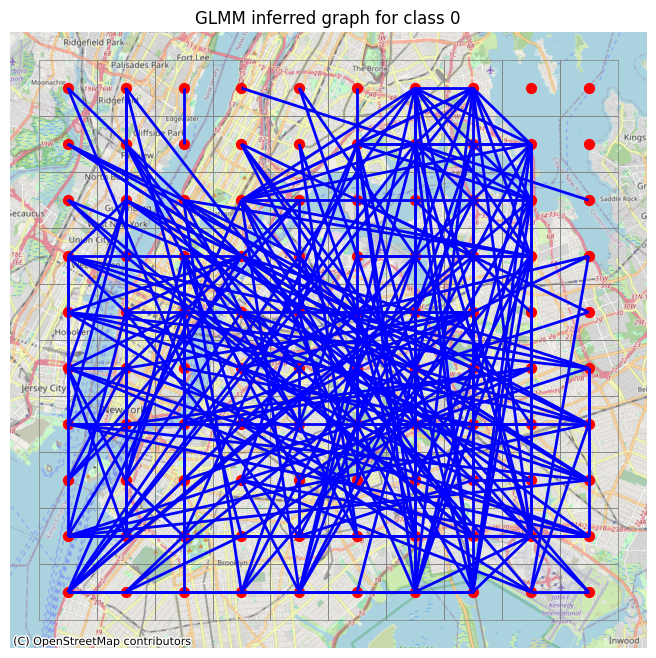

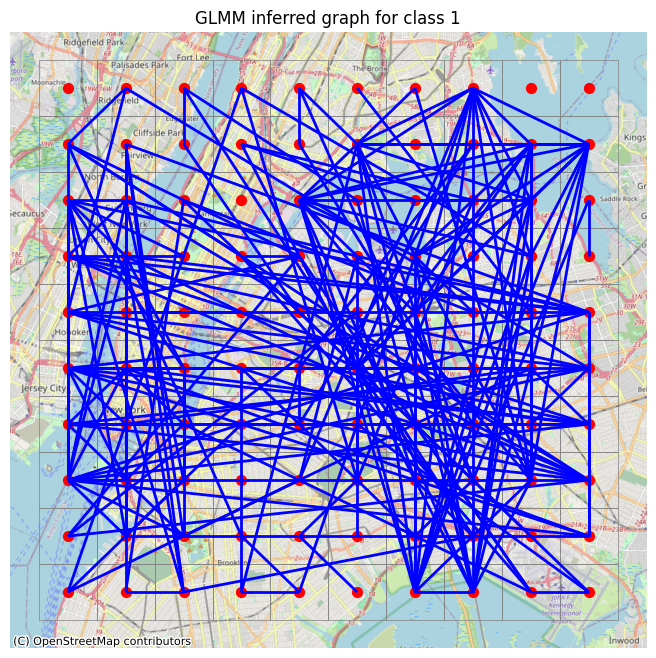

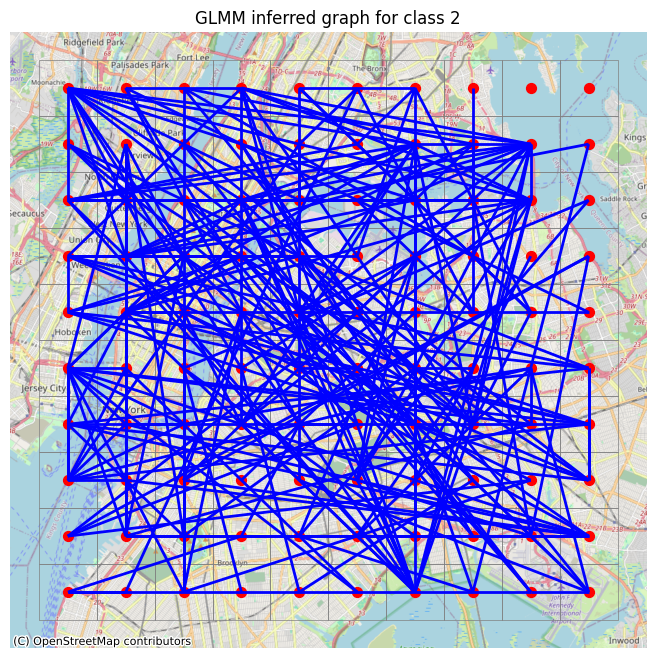

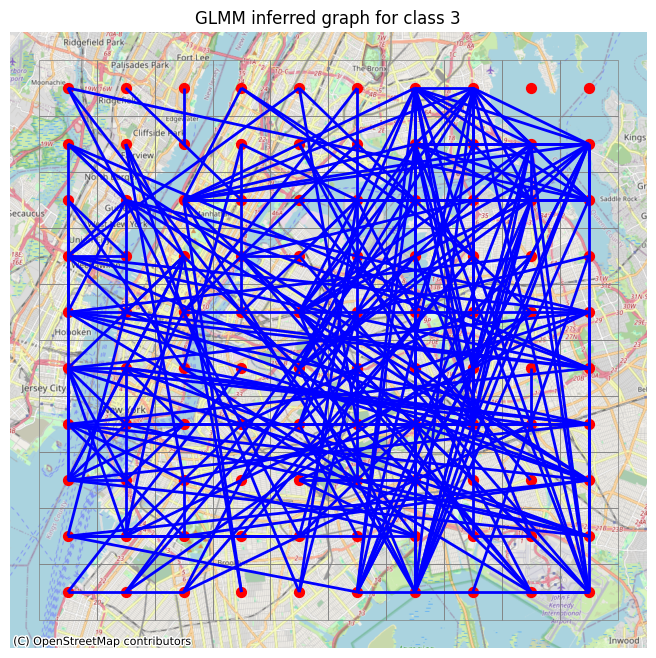

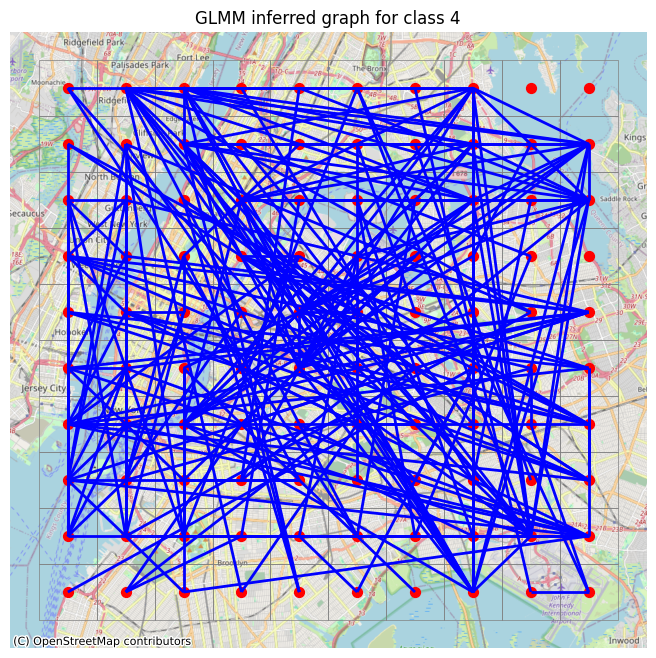

In [79]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv
from scipy.stats import multivariate_normal
import contextily as ctx
from shapely.geometry import Point, Polygon, LineString
import datetime

# Function to load and preprocess the data without taxi zones shapefile
def load_and_preprocess_data():
    # Load Uber pickups data
    uber_data = pd.read_csv('/Users/paul_reitz/Downloads/uber-raw-data-sep14.csv')

    # Convert Date/Time to datetime object
    uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format='%m/%d/%Y %H:%M:%S')

    # Filter to working days (Monday to Friday)
    uber_data = uber_data[uber_data['Date/Time'].dt.weekday < 5]

    # Define NYC bounding box (approximate)
    min_lon, max_lon = -74.05, -73.75
    min_lat, max_lat = 40.63, 40.85

    # Filter data within the bounding box
    uber_data = uber_data[(uber_data['Lon'] >= min_lon) & (uber_data['Lon'] <= max_lon) &
                          (uber_data['Lat'] >= min_lat) & (uber_data['Lat'] <= max_lat)]

    # Define grid size
    n_lon_cells = 10
    n_lat_cells = 10

    # Compute cell size
    lon_step = (max_lon - min_lon) / n_lon_cells
    lat_step = (max_lat - min_lat) / n_lat_cells

    # Assign pickups to grid cells
    uber_data['Lon_idx'] = ((uber_data['Lon'] - min_lon) / lon_step).astype(int)
    uber_data['Lat_idx'] = ((uber_data['Lat'] - min_lat) / lat_step).astype(int)

    # Ensure indices are within [0, n_cells - 1]
    uber_data['Lon_idx'] = uber_data['Lon_idx'].clip(0, n_lon_cells - 1)
    uber_data['Lat_idx'] = uber_data['Lat_idx'].clip(0, n_lat_cells - 1)

    # Create a unique cell ID
    uber_data['Cell_ID'] = uber_data['Lat_idx'] * n_lon_cells + uber_data['Lon_idx']

    # Total number of cells
    n_cells = n_lon_cells * n_lat_cells

    # Aggregate pickups per hour per cell
    uber_data['Hour'] = uber_data['Date/Time'].dt.hour
    uber_data['Date'] = uber_data['Date/Time'].dt.date

    # Create a pivot table: rows are hours, columns are cells
    hourly_pickups = uber_data.pivot_table(index=['Date', 'Hour'], columns='Cell_ID', values='Base', aggfunc='count', fill_value=0)

    # Flatten MultiIndex
    hourly_pickups.reset_index(inplace=True)

    # Create a datetime index
    hourly_pickups['DateTime'] = pd.to_datetime(hourly_pickups['Date'].astype(str) + ' ' + hourly_pickups['Hour'].astype(str), format='%Y-%m-%d %H')

    # Sort by datetime
    hourly_pickups.sort_values('DateTime', inplace=True)

    # Drop unnecessary columns
    hourly_pickups.drop(columns=['Date', 'Hour', 'DateTime'], inplace=True)

    # Replace NaNs with zeros (in case some cells have no pickups in certain hours)
    hourly_pickups.fillna(0, inplace=True)

    # Convert to NumPy array
    data = hourly_pickups.values

    # Normalize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Create cell mapping to coordinates (for visualization)
    cell_coords = {}
    for cell_id in range(n_cells):
        lon_idx = cell_id % n_lon_cells
        lat_idx = cell_id // n_lon_cells
        lon_center = min_lon + (lon_idx + 0.5) * lon_step
        lat_center = min_lat + (lat_idx + 0.5) * lat_step
        cell_coords[cell_id] = (lon_center, lat_center)

    return data_scaled, cell_coords, n_cells, n_lon_cells, n_lat_cells, lon_step, lat_step, min_lon, max_lon, min_lat, max_lat

# Visualization function
def visualize_graphs(Ls, cell_coords, n_cells, n_lon_cells, n_lat_cells, lon_step, lat_step, min_lon, max_lon, min_lat, max_lat, method_name='GLMM'):
    classes = Ls.shape[2]

    # Create GeoDataFrame for cells
    cells = []
    for cell_id in range(n_cells):
        lon_idx = cell_id % n_lon_cells
        lat_idx = cell_id // n_lon_cells
        lon_min = min_lon + lon_idx * lon_step
        lon_max = lon_min + lon_step
        lat_min = min_lat + lat_idx * lat_step
        lat_max = lat_min + lat_step
        polygon = Polygon([(lon_min, lat_min), (lon_max, lat_min), (lon_max, lat_max), (lon_min, lat_max)])
        cells.append({'Cell_ID': cell_id, 'geometry': polygon})
    cells_gdf = gpd.GeoDataFrame(cells, crs='EPSG:4326')

    # Get positions for nodes
    pos = {cell_id: cell_coords[cell_id] for cell_id in cell_coords}

    for cls in range(classes):
        L = Ls[:, :, cls]
        # Compute the adjacency matrix W
        W = np.diag(np.diag(L)) - L
        # Threshold the weights for visualization
        threshold = np.percentile(W, 95)  # Adjust the percentile as needed
        W_thresholded = np.copy(W)
        W_thresholded[W_thresholded < threshold] = 0

        # Create the graph from the adjacency matrix
        G = nx.from_numpy_array(W_thresholded)

        # Create GeoDataFrames for nodes and edges
        nodes_gdf = gpd.GeoDataFrame({
            'id': list(pos.keys()),
            'geometry': [Point(pos[i]) for i in pos]
        }, crs='EPSG:4326')

        edges = []
        for u, v in G.edges():
            line = LineString([pos[u], pos[v]])
            edges.append({'geometry': line, 'u': u, 'v': v})
        edges_gdf = gpd.GeoDataFrame(edges, crs='EPSG:4326')

        # Convert to Web Mercator for plotting
        nodes_gdf.to_crs(epsg=3857, inplace=True)
        edges_gdf.to_crs(epsg=3857, inplace=True)
        cells_gdf.to_crs(epsg=3857, inplace=True)

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot cells
        cells_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

        # Plot edges
        edges_gdf.plot(ax=ax, linewidth=2, edgecolor='blue')

        # Plot nodes
        nodes_gdf.plot(ax=ax, markersize=50, color='red')

        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        # Set plot title and axis off
        plt.title(f'{method_name} inferred graph for class {cls}')
        plt.axis('off')
        plt.show()

# Main function
def main():
    # Load and preprocess data
    data_scaled, cell_coords, n_cells, n_lon_cells, n_lat_cells, lon_step, lat_step, min_lon, max_lon, min_lat, max_lat = load_and_preprocess_data()

    # Apply the GLMM algorithm
    iterations = 10
    classes = 5
    Ls, gamma_hat, mu, log_likelihood = glmm(data_scaled, iterations, classes)

    print('Training done')
    print('Sum of gamma_hat:', np.sum(gamma_hat, axis=0))

    # Visualize the inferred graphs
    visualize_graphs(Ls, cell_coords, n_cells, n_lon_cells, n_lat_cells, lon_step, lat_step, min_lon, max_lon, min_lat, max_lat, method_name='GLMM')

if __name__ == '__main__':
    main()